<a href="https://colab.research.google.com/github/krystaldowling/MAST30034_Final_Project-/blob/ml_tfidf/tf_idf_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.model_selection import train_test_split

news_data = pd.read_csv("/content/drive/My Drive/Data/final_preproccessed_data.csv")

news_data.index.name = 'index'

news_train, news_test, label_train, label_test = train_test_split(news_data.loc[:,['title','text']], 
                                                        news_data.loc[:,'label'], test_size=0.25, 
                                                        random_state=88)

In [ ]:
def count_vect(X_train, body):
  '''
  function converts a text to a matrix of token counts
  returns a sparse matrix of counts
  '''
  count_vectoriser = CountVectorizer()
  X_train_counts = count_vectoriser.fit_transform(X_train)
  
  # Save the vectorizer
  vec_file = body + '_vectorizer.pickle'
  pickle.dump(count_vectoriser, open(vec_file, 'wb'))

  return X_train_counts, count_vectoriser

train_text_counts, text_count_vec = count_vect(news_train['text'], 'text')
train_title_counts, title_count_vec = count_vect(news_train['title'], 'title')



def tfidf_count_transform(X_train_counts, body):  
  '''
  function transforms count matrix to a normalized tf-idf representation
  scales down the effect of words that appear frequently in a corpus
  '''
  tfidf_transformer = TfidfTransformer()
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

  # Save the trasnformer
  vec_file = body + '_transformer.pickle'
  pickle.dump(tfidf_transformer, open(vec_file, 'wb'))

  return X_train_tfidf, tfidf_transformer

train_text_tfidf, text_tfidf_transformer = tfidf_count_transform(train_text_counts, 'text')
train_title_tfidf, title_tfidf_transformer  = tfidf_count_transform(train_title_counts, 'title')



def fit_vectoriser_test(X_test, vectoriser):
  '''
  function loads pickle vectoriser
  fits the vectoriser to the test data
  '''
  # load the vectorizer
  loaded_vectoriser = pickle.load(open(vectoriser, 'rb'))
  test_vectorised = loaded_vectoriser.transform(X_test)

  return test_vectorised

title_count_vec_test = fit_vectoriser_test(news_test['title'], 'title_vectorizer.pickle')
title_tfidf_test = fit_vectoriser_test(title_count_vec_test, 'title_transformer.pickle')

text_count_vec_test = fit_vectoriser_test(news_test['text'], 'text_vectorizer.pickle')
text_tfidf_test = fit_vectoriser_test(text_count_vec_test, 'text_transformer.pickle')


In [ ]:
def feature_selection(X_train, y_train, X_test, k):
    '''
    function selects k best features based on chi squared test
    and mutual information
    '''
    x2 = SelectKBest(chi2, k)
    x2.fit(X_train,y_train)
    X_train_x2 = x2.transform(X_train)
    X_test_x2 = x2.transform(X_test)


    mi = SelectKBest(mutual_info_classif, k)
    mi.fit(X_train,y_train)
    X_train_mi = mi.transform(X_train)
    X_test_mi = mi.transform(X_test)
    
    return X_train_x2, X_test_x2, X_train_mi, X_test_mi 

In [ ]:
def train_models(X_train_x2, X_test_x2, X_train_mi, X_test_mi, y_train, y_test, k):
    '''
    function fits Gaussian Naive Bayes, Multinomial Naive Bayes, 
    Logistic Regression and Support Vector Classification models
    on training data - finds the accuracy score of the model on the test data
    '''
  
    models = [GaussianNB(),
                MultinomialNB()]
#                 SVC(),
#                 LogisticRegression()]

    titles = ['GNB',
                'MNB']
#                 'SVC',
#                 'Logistic Regression']


    Xs = [(X_train_x2, X_test_x2), (X_train_mi, X_test_mi)]
     
  
    X_names = ['x2', 'mi']
    

    for title, model in zip(titles, models):
        print('\n',title)
        for X_name, X in zip(X_names, Xs):
            print(X_name, 'with ', k, ' features:')
            X_train_t, X_test_t = X
            model.fit(X_train_t.todense(), y_train)
            y_pred = model.predict(X_test_t.todense())
            acc = model.score(X_test_t.todense(), y_test)
            print('accuracy score',  acc)
            print('F1 score: {:3f}'.format(f1_score(y_test, y_pred)))
            print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))

    return acc


In [ ]:
X_train_x2, X_test_x2, X_train_mi, X_test_mi = feature_selection(train_text_tfidf, label_train, text_tfidf_test, 10)


 GNB


TypeError: ignored

In [ ]:
train_models(X_train_x2, X_test_x2, X_train_mi, X_test_mi, label_train, label_test, 10)


 GNB
x2 - with  10  features:
accuracy score 0.7259556103575833
F1 score: 0.604713
AUC score: 0.697155
mi - with  10  features:
accuracy score 0.626078914919852
F1 score: 0.494091
AUC score: 0.601743

 MNB
x2 - with  10  features:
accuracy score 0.6420057542129058
F1 score: 0.312278
AUC score: 0.587722
mi - with  10  features:
accuracy score 0.5679202630497329
F1 score: 0.000000
AUC score: 0.500000


In [ ]:
# fit Naive bayes models to data with different values of k to find best number fo features
for k in range(50, 501, 50):
    X_train_x2, X_test_x2, X_train_mi, X_test_mi = feature_selection(train_text_tfidf, label_train, text_tfidf_test, k)
    acc = train_models(X_train_x2, X_test_x2, X_train_mi, X_test_mi, label_train, label_test, k)


 GNB
x2 with  50  features:
accuracy score 0.7488697081792026
F1 score: 0.643107
AUC score: 0.721936
mi with  50  features:
accuracy score 0.6635840526099466
F1 score: 0.611533
AUC score: 0.657516

 MNB
x2 with  50  features:
accuracy score 0.6975955610357584
F1 score: 0.483231
AUC score: 0.653302
mi with  50  features:
accuracy score 0.5688450472667489
F1 score: 0.005216
AUC score: 0.501127

 GNB
x2 with  100  features:
accuracy score 0.7269831483764899
F1 score: 0.580584
AUC score: 0.692343
mi with  100  features:
accuracy score 0.7084874640361694
F1 score: 0.640112
AUC score: 0.695513

 MNB
x2 with  100  features:
accuracy score 0.7278051787916153
F1 score: 0.561496
AUC score: 0.689000
mi with  100  features:
accuracy score 0.5802507192766132
F1 score: 0.061567
AUC score: 0.514667

 GNB
x2 with  150  features:
accuracy score 0.7283189478010687
F1 score: 0.582965
AUC score: 0.693775
mi with  150  features:
accuracy score 0.717632552404439
F1 score: 0.663812
AUC score: 0.708968

 MNB

NameError: ignored

In [ ]:
# dictionary of accuracy by number of features for gaussian naive bayes model
GNB_x2_accuracy = dict({(50, 0.7488697081792026), (100, 0.7269831483764899), (150, 0.7283189478010687), 
                       (200, 0.7385943279901356), (250, 0.7305795314426634), (300, 0.7410604192355117), 
                       (350, 0.7332511302918208), (400, 0.7304767776407727), (450, 0.7323263460748047), 
                       (500, 0.7380805589806823)})

In [ ]:
print(GNB_x2_accuracy)

{50: 0.7488697081792026, 350: 0.7332511302918208, 300: 0.7410604192355117, 250: 0.7305795314426634, 200: 0.7385943279901356, 500: 0.7380805589806823, 450: 0.7323263460748047, 400: 0.7304767776407727, 150: 0.7283189478010687, 100: 0.7269831483764899}


In [ ]:
# dictionary of accuracy by number of features for multinomial naive bayes model

MNB_x2_accuracy = dict({(50, 0.6975955610357584), (100, 0.7278051787916153), (150, 0.7428072338676531), 
                    (200, 0.7567817509247842), (250, 0.7642827784628031), (300, 0.7721948212083847), 
                    (350, 0.7797986025482943), (400, 0.7827784628031237), (450, 0.7866831072749692), 
                    (500, 0.7897657213316893)})

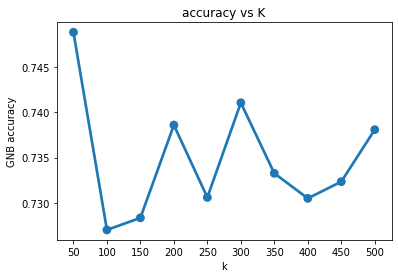

In [ ]:
# plot k vs accuracy for GNB model
plt.xlabel('k (chi-squared)') 
plt.ylabel('GNB accuracy')
sns.pointplot(x=list(GNB_x2_accuracy.keys()), y=list(GNB_x2_accuracy.values()))
plt.title('accuracy vs K')
plt.show()

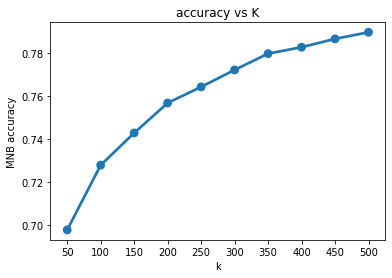

In [ ]:
# plot k vs accuracy for MNB model
plt.xlabel('k (chi-squared)') 
plt.ylabel('MNB accuracy')
sns.pointplot(x=list(MNB_x2_accuracy.keys()), y=list(MNB_x2_accuracy.values()))
plt.title('accuracy vs K')
plt.show()

In [ ]:
# attempt to print best words for prediciton
x2 = SelectKBest(chi2, 50)
x2.fit(train_text_tfidf,label_train)

for feat_num in x2.get_support(indices=True):
    print(text_tfidf_transformer.get_feature_names()[feat_num])

AttributeError: ignored

In [ ]:
# fit MNB with 1000 best features by chi-squared test
x2 = SelectKBest(chi2, 1000)
x2.fit(train_text_tfidf,label_train)
X_train_x2 = x2.transform(train_text_tfidf)
X_test_x2 = x2.transform(text_tfidf_test)

model = MultinomialNB()
model.fit(X_train_x2.todense(), label_train)
y_pred = model.predict(X_test_x2.todense())
acc = model.score(X_test_x2.todense(), label_test)
print('accuracy score',  acc)
print('F1 score: {:3f}'.format(f1_score(label_test, y_pred)))

accuracy score 0.8103164817098233
F1 score: 0.739853


In [ ]:
print(train_text_tfidf.shape)

(19757, 137482)


In [ ]:
# fit MNB with 20000 best features by chi-squared test
x2 = SelectKBest(chi2, 20000)
x2.fit(train_text_tfidf,label_train)
X_train_x2 = x2.transform(train_text_tfidf)
X_test_x2 = x2.transform(text_tfidf_test)

model = MultinomialNB()
model.fit(X_train_x2.todense(), label_train)
y_pred = model.predict(X_test_x2.todense())
acc = model.score(X_test_x2.todense(), label_test)
print('accuracy score',  acc)
print('F1 score: {:3f}'.format(f1_score(label_test, y_pred)))
print('precision score: {:3f}'.format(precision_score(label_test, y_pred)))
print('recall score: {:3f}'.format(recall_score(label_test, y_pred)))

accuracy score 0.8352095483520955
F1 score: 0.787995
precision score: 0.890028
recall score: 0.706951


In [ ]:
text_counts, text_count_vec = count_vect(news_data['text'], 'text')
text_tfidf, all_text_tfidf_transformer = tfidf_count_transform(text_counts, 'text')

# find 20000 best features
x2 = SelectKBest(chi2, 20000)
x2.fit(text_tfidf, news_data['label'])
tfidf_text_x2 = x2.transform(text_tfidf)

# perform grid search for log reg parameters to find the best
gs = GridSearchCV(LogisticRegression(), 
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1], 
                         'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}, 
                          scoring="accuracy", cv=4)
gs = gs.fit(tfidf_text_x2, news_data['label'])
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))

{'C': 1, 'solver': 'saga'}
best score: 0.797652


NameError: ignored

In [ ]:
# fit best log reg model with 20000 best features 
x2 = SelectKBest(chi2, 20000)
x2.fit(train_text_tfidf,label_train)
X_train_x2 = x2.transform(train_text_tfidf)
X_test_x2 = x2.transform(text_tfidf_test)

lr_best = LogisticRegression(C = 1, solver='saga')
lr_best.fit(X_train_x2.todense(), label_train)
y_pred = lr_best.predict(X_test_x2.todense())
acc = lr_best.score(X_test_x2.todense(), label_test)
print('accuracy score',  acc)
print('F1 score: {:3f}'.format(f1_score(label_test, y_pred)))

accuracy score 0.8669338265515824
F1 score: 0.840301


In [ ]:
text_counts, text_count_vec = count_vect(news_data['text'], 'text')
text_tfidf, all_text_tfidf_transformer = tfidf_count_transform(text_counts, 'text')

# find 20000 best features
x2 = SelectKBest(chi2, 20000)
x2.fit(text_tfidf, news_data['label'])
tfidf_text_x2 = x2.transform(text_tfidf)

# perform grid search for SVM parameters to find the best
gs = GridSearchCV(SVC(C=1), 
             param_grid={'kernel':['linear', 'poly', 'rbf', 'sigmoid']}, 
                          scoring="accuracy", cv=4)
gs = gs.fit(tfidf_text_x2, news_data['label'])
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))

{'kernel': 'linear'}
best score: 0.806232


In [ ]:
# fit best SVM model with different values of k features to find the best performing model
for k in range(50, 501, 50):
    x2 = SelectKBest(chi2, k)
    x2.fit(train_text_tfidf,label_train)
    X_train_x2 = x2.transform(train_text_tfidf)
    X_test_x2 = x2.transform(text_tfidf_test)

    svm = SVC(C = 1, kernel = 'linear')
    svm.fit(X_train_x2.todense(), label_train)
    y_pred = svm.predict(X_test_x2.todense())

    acc = svm.score(X_test_x2.todense(), label_test)
    print('\n', k, 'features')
    print('accuracy score',  acc)
    print('F1 score: {:3f}'.format(f1_score(label_test, y_pred)))


 50 features
accuracy score 0.7787710645293876
F1 score: 0.694393

 100 features
accuracy score 0.801993423756679
F1 score: 0.737573

 150 features
accuracy score 0.8135018495684341
F1 score: 0.759443

 200 features
accuracy score 0.8248047677764078
F1 score: 0.777386

 250 features
accuracy score 0.8295314426633785
F1 score: 0.786294

 300 features
accuracy score 0.8345663789560214
F1 score: 0.793484

 350 features
accuracy score 0.8376489930127414
F1 score: 0.798109

 400 features
accuracy score 0.8402178380600083
F1 score: 0.802238

 450 features
accuracy score 0.8431976983148376
F1 score: 0.806542

 500 features
accuracy score 0.8454582819564324
F1 score: 0.809668


In [ ]:
# SVM model with 5000 features
x2 = SelectKBest(chi2, 5000)
x2.fit(train_text_tfidf,label_train)
X_train_x2 = x2.transform(train_text_tfidf)
X_test_x2 = x2.transform(text_tfidf_test)

svm = SVC(C = 1, kernel = 'linear')
svm.fit(X_train_x2.todense(), label_train)
y_pred = svm.predict(X_test_x2.todense())

acc = svm.score(X_test_x2.todense(), label_test)
print('\n 1000 features')
print('accuracy score',  acc)
print('F1 score: {:3f}'.format(f1_score(label_test, y_pred)))


 1000 features
accuracy score 0.8708384710234278
F1 score: 0.844450


In [ ]:
# SVM model with 10000 features - BEST MODEL
x2 = SelectKBest(chi2, 10000)
x2.fit(train_text_tfidf,label_train)
X_train_x2 = x2.transform(train_text_tfidf)
X_test_x2 = x2.transform(text_tfidf_test)

svm = SVC(C = 1, kernel = 'linear')
svm.fit(X_train_x2.todense(), label_train)
y_pred = svm.predict(X_test_x2.todense())

acc = svm.score(X_test_x2.todense(), label_test)
print('\n 10000 features')
print('accuracy score',  acc)
print('F1 score: {:3f}'.format(f1_score(label_test, y_pred)))
print('precision score: {:3f}'.format(precision_score(label_test, y_pred)))
print('recall score: {:3f}'.format(recall_score(label_test, y_pred)))